## Finetuning the model trained on lcs on just one hcs and then testing on the rest

In [1]:
import os 
import sys
import pandas as pd 
import numpy as np
import pickle 
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import StandardScaler
from gpr_unsupervised_all_sensors import NUM_NEAREST_SENSORS, model_save_path, NUM_LAST_DAYS

NUM_LAST_DAYS = 12, NUM_NEAREST_SENSORS = 10


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def get_location_specific_lcs_data(location, df):
    
    '''
    location : string, the location for which you want the lcs sensors
    
    returns df containing the lcs for that location
    '''
    
    columns_to_return = []
    for col in df.columns: 
        if location in col:
            columns_to_return.append(col)
            
    return df[columns_to_return]

In [4]:
def get_location_specific_hcs_data(location_index, df):
    
    '''
    
    location_index : int, the index for which we want the hcs sensors data
    returns df containing that hcs
    
    '''
    
    columns_to_return = []
    for x in list(df.columns): 
        if int(x.split('_')[-1]) == int(location_index):
            columns_to_return.append(x)
            
    return df[columns_to_return]

In [5]:
def get_k_closest_sensors_data(input_loc, df, k):

    '''
    input_loc : pair of (lat, long) of hcs location
    df : has say n sensors (each sensor is taking 5 columns [pm, temp, rh, lat, long])
    of these n sensors we return a dataframe containing all the data for k nearest sensors 
    '''
    
    column_groups = [df.columns[i*5:i*5+5] for i in range(int(df.shape[1]/5))]
    sensors_coord = [(df.iloc[0, i*5+3], df.iloc[0, i*5+4]) for i in range(int(df.shape[1]/5))]
    
    sensors_dist = [abs(input_loc[0] - x) + abs(input_loc[1] - y)  for (x, y) in sensors_coord]
    
    indices_list = list(range(len(sensors_dist)))
    sorted_indices_list = sorted(indices_list, key = lambda i : sensors_dist[i])
    top_k_indices_list = sorted_indices_list[:k] # these indices groups need to be included
    # print(top_k_indices_list)
    
    columns_to_return = []
    for index in top_k_indices_list:
        columns_to_return += column_groups[index].tolist()
    
    return df[columns_to_return]

In [6]:
def normalize_prep_data(num_last_train_entries_to_use:int, use_first:bool , train_sensor_lcs_data, train_sensor_hcs_data):
    
    # train_sensor_lcs_data.shape = (510, 5*num_train_sensor_lcs_data)
    # 
    for i in range(0, int(train_sensor_lcs_data.shape[1]/5), 5):
        train_sensor_lcs_data.iloc[:, i*5+1] = train_sensor_lcs_data.iloc[:, i*5+1] - train_sensor_hcs_data.iloc[:, 4] # temp
        train_sensor_lcs_data.iloc[:, i*5+2] = train_sensor_lcs_data.iloc[:, i*5+2] - train_sensor_hcs_data.iloc[:, 3] # rh 
        train_sensor_lcs_data.iloc[:, i*5+3] = train_sensor_lcs_data.iloc[:, i*5+3] - train_sensor_hcs_data.iloc[:, 7] # lat
        train_sensor_lcs_data.iloc[:, i*5+4] = train_sensor_lcs_data.iloc[:, i*5+4] - train_sensor_hcs_data.iloc[:, 8] # long
        
    # for First : use from the starting    
    
    if use_first:
        train_X = train_sensor_lcs_data.values[:num_last_train_entries_to_use, :]
        train_y = train_sensor_hcs_data.values[:num_last_train_entries_to_use, 2] 
        
    else:
        # for Last : use from the last
        train_X = train_sensor_lcs_data.values[-num_last_train_entries_to_use:, :]
        train_y = train_sensor_hcs_data.values[-num_last_train_entries_to_use:, 2] 
    
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    
    return train_X, train_y

In [7]:
with open("data/hcsIndex2Name.json", "r") as f: 
    hcsIndex2Name = json.load(f)

with open("data/hcsName2Index.json", "r") as f: 
    hcsName2Index = json.load(f)

In [8]:
lcs_data = pd.read_csv('data/AQI_LCS_data_prep.csv')
lcs_data = lcs_data.iloc[:, 2:]
print(f"lcs_data.shape = {lcs_data.shape}")
lcs_data.head()

lcs_data.shape = (510, 1235)


,PM25_1201230029_ARARIA_ARARIA,Temp_1201230029_ARARIA_ARARIA,RH_1201230029_ARARIA_ARARIA,lat_PM25_1201230029_ARARIA_ARARIA,long_PM25_1201230029_ARARIA_ARARIA,PM25_1201230033_KURSAKANTA_ARARIA,Temp_1201230033_KURSAKANTA_ARARIA,RH_1201230033_KURSAKANTA_ARARIA,lat_PM25_1201230033_KURSAKANTA_ARARIA,long_PM25_1201230033_KURSAKANTA_ARARIA,...,PM25_BCDDC247BFE3_BHITAHA_WCHAMPARAN,Temp_BCDDC247BFE3_BHITAHA_WCHAMPARAN,RH_BCDDC247BFE3_BHITAHA_WCHAMPARAN,lat_PM25_BCDDC247BFE3_BHITAHA_WCHAMPARAN,long_PM25_BCDDC247BFE3_BHITAHA_WCHAMPARAN,PM25_DC4F22364445_PIPRASI_WCHAMPARAN,Temp_DC4F22364445_PIPRASI_WCHAMPARAN,RH_DC4F22364445_PIPRASI_WCHAMPARAN,lat_PM25_DC4F22364445_PIPRASI_WCHAMPARAN,long_PM25_DC4F22364445_PIPRASI_WCHAMPARAN
0,8.0,32.0,98.0,26.148,87.457,26.0,30.5,90.0,26.359,87.443,...,14.55,38.25,50.36,26.907,84.136,18.02,35.59,57.30,27.06,84.023
1,6.0,33.0,98.0,26.148,87.457,20.5,30.5,90.0,26.359,87.443,...,11.22,38.82,50.36,26.907,84.136,13.92,36.46,57.30,27.06,84.023
2,6.5,34.5,98.0,26.148,87.457,12.5,30.0,90.0,26.359,87.443,...,15.26,38.46,50.36,26.907,84.136,14.37,35.90,57.30,27.06,84.023
3,13.0,33.5,98.0,26.148,87.457,15.5,30.0,88.0,26.359,87.443,...,37.81,39.47,47.59,26.907,84.136,11.13,36.68,56.93,27.06,84.023
4,10.0,34.0,98.0,26.148,87.457,10.0,32.0,82.5,26.359,87.443,...,15.55,39.96,46.83,26.907,84.136,11.48,38.89,51.65,27.06,84.023


In [9]:
locations_to_test_loc = ['BHAGALPUR', 'KATIHAR', 'SAMASTIPUR', 'SIWAN', 'HAJIPUR']
location_to_test_loc_index_dict = {loc: i for i, loc in enumerate(locations_to_test_loc)}
print(location_to_test_loc_index_dict)
locations_to_test_index = [hcsName2Index[x.lower()] for x in locations_to_test_loc]

print(locations_to_test_index)

{'BHAGALPUR': 0, 'KATIHAR': 1, 'SAMASTIPUR': 2, 'SIWAN': 3, 'HAJIPUR': 4}
[3, 8, 16, 18, 17]


In [10]:
hcs_data = pd.read_csv('data/hcsdatacleaned.csv')
hcs_data = hcs_data.iloc[:, 1:]
print(f"hcs_data.shape = {hcs_data.shape}")
hcs_data.head()

hcs_data.shape = (510, 99)


,From Date_3,To Date_3,PM2.5_3,RH_3,AT_3,WS_3,WD_3,lat_3,long_3,From Date_4,...,long_17,From Date_18,To Date_18,PM2.5_18,RH_18,AT_18,WS_18,WD_18,lat_18,long_18
0,26-07-2023 09:00,26-07-2023 09:15,12.0,76.0,31.2,3.0,229.0,25.262,87.011,26-07-2023 09:00,...,85.245,26-07-2023 09:00,26-07-2023 09:15,39.0,64.0,34.4,1.5,19.0,26.227,84.357
1,26-07-2023 10:00,26-07-2023 10:15,7.0,73.0,31.9,3.0,356.0,25.262,87.011,26-07-2023 10:00,...,85.245,26-07-2023 10:00,26-07-2023 10:15,25.0,62.0,35.1,1.6,29.0,26.227,84.357
2,26-07-2023 11:00,26-07-2023 11:15,2.0,69.0,32.7,3.5,353.0,25.262,87.011,26-07-2023 11:00,...,85.245,26-07-2023 11:00,26-07-2023 11:15,28.0,57.0,36.1,1.7,12.0,26.227,84.357
3,26-07-2023 12:00,26-07-2023 12:15,6.0,64.0,34.1,3.4,354.0,25.262,87.011,26-07-2023 12:00,...,85.245,26-07-2023 12:00,26-07-2023 12:15,25.0,56.0,36.9,1.5,31.0,26.227,84.357
4,26-07-2023 13:00,26-07-2023 13:15,15.0,62.0,34.7,3.3,358.0,25.262,87.011,26-07-2023 13:00,...,85.245,26-07-2023 13:00,26-07-2023 13:15,23.0,57.0,37.2,1.5,354.0,26.227,84.357


In [11]:
hcs_data_list = [get_location_specific_hcs_data(x, hcs_data) for x in locations_to_test_index]
for i, x in enumerate(hcs_data_list): 
    print(f"i = {i}, location = {locations_to_test_loc[i]}, x.shape = {x.shape}")

i = 0, location = BHAGALPUR, x.shape = (510, 9)
i = 1, location = KATIHAR, x.shape = (510, 9)
i = 2, location = SAMASTIPUR, x.shape = (510, 9)
i = 3, location = SIWAN, x.shape = (510, 9)
i = 4, location = HAJIPUR, x.shape = (510, 9)


In [12]:
def prepare_train_test(location_to_train: str, num_last_train_days: int, use_first: bool, num_train_sensor_lcs=NUM_NEAREST_SENSORS, num_hcs_data_list=hcs_data_list, lcs_data=lcs_data):
    
    '''
    location_to_train : string, location for which we want to train the model
    num_last_train_days : int, number of last days of data to train on
    
    returns X_train, X_test, y_train, y_test
    '''
    
    num_train_entries_to_use = int(24 * num_last_train_days)
    
    location_to_train_index = location_to_test_loc_index_dict[location_to_train]
    train_sensor_hcs_data = hcs_data_list[location_to_train_index] # we will be finetuning on this data
    test_sensor_hcs_data = hcs_data_list[:location_to_train_index] + hcs_data_list[location_to_train_index+1:] # this will be used for testing
    
    train_sensor_hcs_loc = (train_sensor_hcs_data.iloc[0, 7], train_sensor_hcs_data.iloc[0, 8])
    train_sensor_lcs_data = get_k_closest_sensors_data(train_sensor_hcs_loc, lcs_data, num_train_sensor_lcs)
    
    
    train_X, train_y = normalize_prep_data(num_train_entries_to_use, use_first, train_sensor_lcs_data, train_sensor_hcs_data)
    
    # now let's get our test set ready
    num_test_entries = int(lcs_data.shape[0]) # testing on all the data
    test_sensor_lcs_data = [get_k_closest_sensors_data((x.iloc[0, 7], x.iloc[0, 8]), lcs_data, num_train_sensor_lcs) for x in test_sensor_hcs_data]
    test_data = [normalize_prep_data(num_test_entries, use_first, test_sensor_lcs_data[i], test_sensor_hcs_data[i]) for i in range(len(test_sensor_hcs_data))]
    
    return train_X, train_y, test_data 
    # numpy_array, numpy_array, list of tuples (numpy_array, numpy_array) :
    #                                           (X_test, y_test) for each location in test_sensor_hcs_data

In [13]:
def give_locations_to_test(location: str, locations_to_test_loc=locations_to_test_loc):
    
    location_list = []
    for x in locations_to_test_loc: 
        if x != location: 
            location_list.append(x)    
    
    return location_list

In [14]:
def convert_to_float(final_results : dict) -> dict:
    for key in final_results.keys():
        results = final_results[key]
        for key in results.keys():
            results[key]['r2'] = results[key]['r2'].astype(np.float64)
            results[key]['mae'] = results[key]['mae'].astype(np.float64)
        final_results[key]=results
    return final_results

In [15]:
locations_to_test_loc 

['BHAGALPUR', 'KATIHAR', 'SAMASTIPUR', 'SIWAN', 'HAJIPUR']

In [17]:
model_save_path = '/Users/architaggarwal/Documents/Projects/AQI/Air-Quality-Index-Calibration/Air-Quality-Index-Calibration_Validation_Exp_Redo/models/NN/unsupervised_lcs_all_data_12days_25epochs_12sensors.h5'

In [18]:
for num_train_last_days in range(1, 22):
    
    save_results_path = f"logs/leave_one_out_finetune_hcs/finetune_{num_train_last_days}_days/NN_{NUM_LAST_DAYS}.json"
    # save_results_path = f"logs/leave_one_out_finetune_hcs/finetune_{num_train_last_days}_days/gpr_self_supervised_{NUM_LAST_DAYS}.json"
    folder_path = "/".join(save_results_path.split('/')[:-1])
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    final_results = {}
    for location in locations_to_test_loc:
        
        print('-' * 100)
        print(f"finetuning_location = {location}")
        
        
        iter_test_locations = give_locations_to_test(location)
        X, y, test_data = prepare_train_test(location, num_last_train_days=num_train_last_days, use_first=True)
        # print(test_data[0][0].shape, test_data[0][1].shape)
        # sys.exit()
        
        #with open(model_save_path, "rb") as f:
        #    model = pickle.load(f)

        model = load_model(model_save_path)
            
        model.verbose = True
        
        
        # using validation set to check for over fitting
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)
        # print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")

    
        # sys.exit()
        X_train = tf.convert_to_tensor(np.asarray(X_train).astype('float32'))
        X_val = tf.convert_to_tensor(np.asarray(X_val).astype('float32'))
        y_train = tf.convert_to_tensor(np.asarray(y_train).astype('float32'))
        y_val = tf.convert_to_tensor(np.asarray(y_val).astype('float32'))

        # fitting the model to the training data
        model.fit(X_train, y_train)
        print('*' * 100)
        
        # getting validation scores
        y_val_hat = model.predict(X_val)
        #val_results = {"r2": r2_score(y_val, y_val_hat),"mae": mean_absolute_error(y_val, y_val_hat), "n_iter_finetune": model.n_iter_, "fit_status": model.fit_status_}
        val_results = {"r2": r2_score(y_val, y_val_hat),"mae": mean_absolute_error(y_val, y_val_hat)}

        
        y_test_hat_list = [model.predict(x) for x, _ in test_data]
        test_results = [(r2_score(y_test, y_test_hat), mean_absolute_error(y_test, y_test_hat)) for (_, y_test), y_test_hat in zip(test_data, y_test_hat_list) ] # (r2_score, mae) 
        
        iter_dict = {"val_results": val_results}
        for i in range(len(iter_test_locations)):
            iter_dict[iter_test_locations[i]] = {"r2": test_results[i][0], "mae": test_results[i][1]}
        
        final_results[location] = iter_dict   
        
    final_results = convert_to_float(final_results)
    with open(save_results_path, "w") as f:
        json.dump(final_results, f, indent=4)

----------------------------------------------------------------------------------------------------
finetuning_location = BHAGALPUR


2024-03-07 20:51:36.955279: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 210ms/step - loss: 1054.8025 - mean_absolute_error: 27.1312
****************************************************************************************************
16/16 [==============================] - 0s 473us/step
----------------------------------------------------------------------------------------------------
finetuning_location = KATIHAR
1/1 [==============================] - 0s 142ms/step - loss: 798.5024 - mean_absolute_error: 25.8308
****************************************************************************************************
16/16 [==============================] - 0s 452us/step
----------------------------------------------------------------------------------------------------
finetuning_location = SAMASTIPUR
1/1 [==============================] - 0s 146ms/step - loss: 550.2859 - mean_absolute_error: 19.6929
****************************************************************************************************
16/16 [===========

In [28]:
with open(save_results_path, "w") as f:
    json.dump(final_results, f, indent=4)

In [29]:
save_results_path

'logs/leave_one_out_finetune_hcs/finetune_21_days/NN_12.json'

### Trying with different number of iterstions for finetuning on Samastipur HCS

- max_iter for finetuning: 245

In [67]:
NUM_LAST_DAYS = 12

# GPR
# model_save_path = f"models/gpr_models/unsupervised_lcs_all_data_{NUM_LAST_DAYS}.pkl"

# Lasso
# alpha = 1
# model_save_path = f"models/lasso_reg/unsupervised_lcs_all_data_{NUM_LAST_DAYS}_alpha_{alpha}.pkl"

# SVR 
available_kernels = ["rbf", "poly", "linear", "sigmoid"]
kernel = available_kernels[1]
model_save_path = f"models/svr/unsupervised_lcs_all_data_{NUM_LAST_DAYS}_kernel_{kernel}.pkl"

In [68]:
iter_test_locations

['BHAGALPUR', 'KATIHAR', 'SIWAN', 'HAJIPUR']

X.shape = (360, 50), y.shape = (360,)
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1
obj = -127.422926, rho = -33.570623
nSV = 2, nBSV = 2
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 2
obj = -174.471435, rho = -25.941196
nSV = 4, nBSV = 4
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 3
obj = -206.912371, rho = -24.245626
nSV = 6, nBSV = 6
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 4
obj = -238.931760, rho = -23.963362
nSV = 8, nBSV = 8
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 5
obj = -267.232204, rho = -23.913721
nSV = 10, nBSV = 10
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 6
obj = -295.624847, rho = -23.549370
nSV = 12, nBSV = 12
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 7
obj = -325.422269, rho = -23.298065
nSV = 14, nBSV = 14
[LibSVM]WARN: libsvm Solver reac

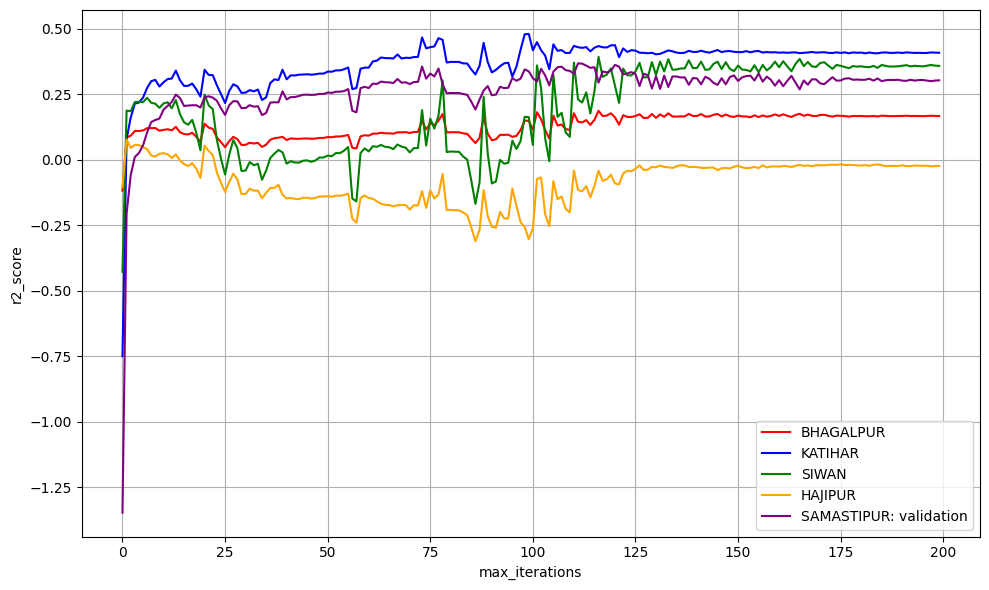

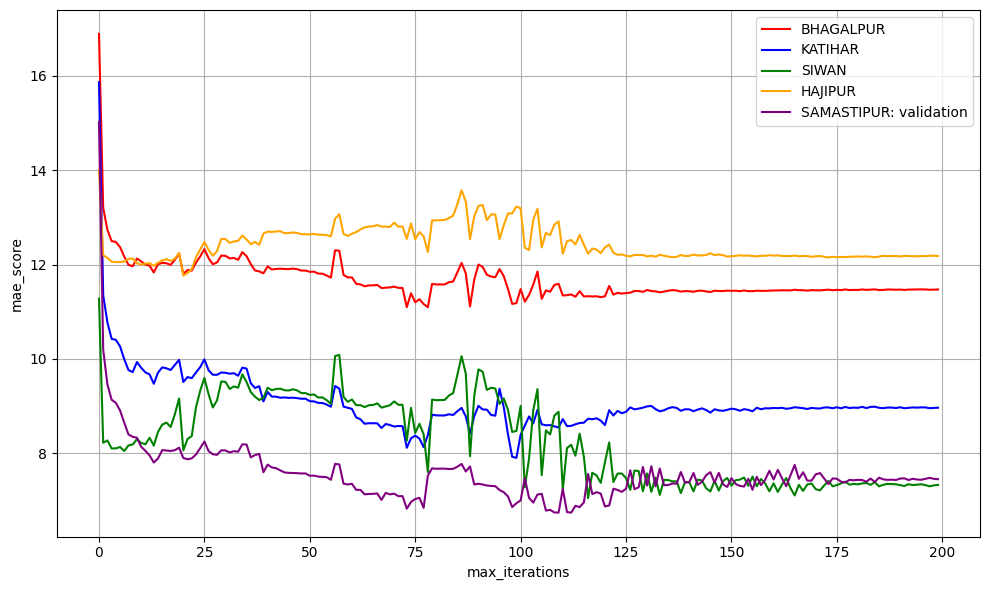

In [69]:
for num_train_last_days in range(15, 16):
    
    save_results_path = f"logs/samastipur_finetune_HCS/finetune_{num_train_last_days}_days/svr_{kernel}_self_supervised_{NUM_LAST_DAYS}.json"
    r2_plot_path = f"logs/samastipur_finetune_HCS/finetune_{num_train_last_days}_days/svr_{kernel}_self_supervised_{NUM_LAST_DAYS}_r2_plot.png"
    mae_plot_path = f"logs/samastipur_finetune_HCS/finetune_{num_train_last_days}_days/svr_{kernel}_self_supervised_{NUM_LAST_DAYS}_mae_plot.png"
    # save_results_path = f"logs/leave_one_out_finetune_hcs/finetune_{num_train_last_days}_days/gpr_self_supervised_{NUM_LAST_DAYS}.json"
    folder_path = "/".join(save_results_path.split('/')[:-1])
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    final_results = {}
    location = "SAMASTIPUR"
    
    iter_test_locations = give_locations_to_test(location)
    X, y, test_data = prepare_train_test(location, num_last_train_days=num_train_last_days, use_first=True)
    print(f"X.shape = {X.shape}, y.shape = {y.shape}")
    # print(test_data[0][0].shape, test_data[0][1].shape)
    # sys.exit()
    
    r2_test_dict = {x: [] for x in iter_test_locations}
    r2_test_dict[location] = [] # for samastipur
    
    mae_test_dict = {x: [] for x in iter_test_locations}
    mae_test_dict[location] = [] # for samastipur
    
    max_iters = 200
    
    for max_allowed_iter in range(1, max_iters+1):
        
        with open(model_save_path, "rb") as f:
            model = pickle.load(f)
        
        model.verbose = True
        model.max_iter = max_allowed_iter
    
        # using validation set to check for over fitting
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)
        # print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
        # sys.exit()
        
        # fitting the model to the training data
        model.fit(X_train, y_train)
        # print('*' * 100)
        
        # getting validation scores
        y_val_hat = model.predict(X_val)
        val_results = {"r2": r2_score(y_val, y_val_hat),"mae": mean_absolute_error(y_val, y_val_hat), "n_iter_finetune": model.n_iter_, "fit_status": model.fit_status_}
        
        r2_test_dict[location].append(val_results["r2"])
        mae_test_dict[location].append(val_results["mae"])
        
        y_test_hat_list = [model.predict(x) for x, _ in test_data]
        test_results = [(r2_score(y_test, y_test_hat), mean_absolute_error(y_test, y_test_hat)) for (_, y_test), y_test_hat in zip(test_data, y_test_hat_list) ] # (r2_score, mae) 
                
        iter_dict = {"val_results": val_results}
        for i in range(len(iter_test_locations)):
            iter_dict[iter_test_locations[i]] = {"r2": test_results[i][0], "mae": test_results[i][1]}
            r2_test_dict[iter_test_locations[i]].append(test_results[i][0])
            mae_test_dict[iter_test_locations[i]].append(test_results[i][1])
        
        final_results[max_allowed_iter] = iter_dict   
    
    # Plot R2 score
    plt.figure(figsize=(10, 6))
    plt.plot(r2_test_dict[iter_test_locations[0]], color='red', label=iter_test_locations[0])
    plt.plot(r2_test_dict[iter_test_locations[1]], color='blue', label=iter_test_locations[1])
    plt.plot(r2_test_dict[iter_test_locations[2]], color='green', label=iter_test_locations[2])
    plt.plot(r2_test_dict[iter_test_locations[3]], color='orange', label=iter_test_locations[3])
    plt.plot(r2_test_dict[location], color='purple', label=f"{location}: validation")
    
    

    # Add labels and legend
    plt.xlabel('max_iterations')
    plt.ylabel('r2_score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(r2_plot_path)
    
    # Plot MAE score
    plt.figure(figsize=(10, 6))
    plt.plot(mae_test_dict[iter_test_locations[0]], color='red', label=iter_test_locations[0])
    plt.plot(mae_test_dict[iter_test_locations[1]], color='blue', label=iter_test_locations[1])
    plt.plot(mae_test_dict[iter_test_locations[2]], color='green', label=iter_test_locations[2])
    plt.plot(mae_test_dict[iter_test_locations[3]], color='orange', label=iter_test_locations[3])
    plt.plot(mae_test_dict[location], color='purple', label=f"{location}: validation")

    # Add labels and legend
    plt.xlabel('max_iterations')
    plt.ylabel('mae_score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(mae_plot_path)
        
    with open(save_results_path, "w") as f:
        json.dump(final_results, f, indent=4)

In [70]:
print(f"X_train.shape = {X_train.shape}, X_val.shape = {X_val.shape}")
print(f"y_train.shape = {y_train.shape}, y_val.shape = {y_val.shape}")

X_train.shape = (241, 50), X_val.shape = (119, 50)
y_train.shape = (241,), y_val.shape = (119,)


- using this above data to fit a RNN

In [73]:
RNN_train_data = {
    "y_train": y_train,
    "y_train_hat": model.predict(X_train),
    "y_val": y_val,
    "y_val_hat": model.predict(X_val),
}

# print(RNN_train_data)

with open("data/RNN_train_data.pkl", "wb") as f:
    pickle.dump(RNN_train_data, f)

### Prep data for RNN

- num_train_last_days = 15(val included), max_iters = 75

In [35]:
NUM_LAST_DAYS = 12

# GPR
# model_save_path = f"models/gpr_models/unsupervised_lcs_all_data_{NUM_LAST_DAYS}.pkl"

# Lasso
# alpha = 1
# model_save_path = f"models/lasso_reg/unsupervised_lcs_all_data_{NUM_LAST_DAYS}_alpha_{alpha}.pkl"

# SVR 
available_kernels = ["rbf", "poly", "linear", "sigmoid"]
kernel = available_kernels[1]
model_save_path = f"models/svr/unsupervised_lcs_all_data_{NUM_LAST_DAYS}_kernel_{kernel}.pkl"

In [36]:
for num_train_last_days in range(15, 16):
    
    save_results_path = f"logs/leave_one_out_finetune_hcs/finetune_{num_train_last_days}_days/svr_{kernel}_self_supervised_{NUM_LAST_DAYS}.json"
    # save_results_path = f"logs/leave_one_out_finetune_hcs/finetune_{num_train_last_days}_days/gpr_self_supervised_{NUM_LAST_DAYS}.json"
    folder_path = "/".join(save_results_path.split('/')[:-1])
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    final_results = {}
    
    for location in ['SAMASTIPUR']:
        
        print('-' * 100)
        print(f"finetuning_location = {location}")
        
        
        iter_test_locations = give_locations_to_test(location)
        X, y, test_data = prepare_train_test(location, num_last_train_days=num_train_last_days, use_first=True)
        # print(test_data[0][0].shape, test_data[0][1].shape)
        # sys.exit()
        
        with open(model_save_path, "rb") as f:
            model = pickle.load(f)
        model.max_iter = 75
        
        # using validation set to check for over fitting
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)
        # print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
        # sys.exit()
        
        # fitting the model to the training data
        model.fit(X_train, y_train)
        print('*' * 100)
        
        # getting validation scores
        y_val_hat = model.predict(X_val)
        val_results = {"r2": r2_score(y_val, y_val_hat),"mae": mean_absolute_error(y_val, y_val_hat), "n_iter_finetune": model.n_iter_, "fit_status": model.fit_status_}
        
        y_test_hat_list = [model.predict(x) for x, _ in test_data]
        test_results = [(r2_score(y_test, y_test_hat), mean_absolute_error(y_test, y_test_hat)) for (_, y_test), y_test_hat in zip(test_data, y_test_hat_list) ] # (r2_score, mae) 
        
        iter_dict = {"val_results": val_results}
        for i in range(len(iter_test_locations)):
            iter_dict[iter_test_locations[i]] = {"r2": test_results[i][0], "mae": test_results[i][1]}
        
        final_results[location] = iter_dict   


----------------------------------------------------------------------------------------------------
finetuning_location = SAMASTIPUR
****************************************************************************************************


In [37]:
print(len(y_test_hat_list), y_test_hat_list[0].shape)

4 (510,)


In [61]:
y_test_hat_dict = {iter_test_locations[i]: {"pred": y_test_hat_list[i], "true": test_data[i][1]} for i in range(len(iter_test_locations))} # (pred, true)
with open("data/y_test_hat_dict_svr_poly_12_finetune_SAMASTIPUR_15.pkl", "wb") as f:
    pickle.dump(y_test_hat_dict, f)

In [65]:
y_test_hat_dict.keys()

dict_keys(['BHAGALPUR', 'KATIHAR', 'SIWAN', 'HAJIPUR'])

In [63]:
y_test_hat_dict['BHAGALPUR']['pred'].shape, y_test_hat_dict['BHAGALPUR']['true'].shape

((510,), (510,))

In [64]:
y_test_hat_dict['BHAGALPUR']['pred'][:10], y_test_hat_dict['BHAGALPUR']['true'][:10]

(array([19.65108039, 17.26886605, 17.82617497, 19.30012254, 17.4181432 ,
        18.36480078, 13.98574895, 11.80170663, 14.00405938, 15.30799212]),
 array([12.0, 7.0, 2.0, 6.0, 15.0, 12.0, 8.0, 8.0, 7.0, 5.0], dtype=object))